# Build CNN

## 1 Import data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import OneHotEncoder

In [6]:
data = loadmat("ex4data1.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [7]:
X = data["X"]
y = data["y"]
X.shape, y.shape

((5000, 400), (5000, 1))

In [8]:
encoder = OneHotEncoder(sparse=False, categories="auto")
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [9]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

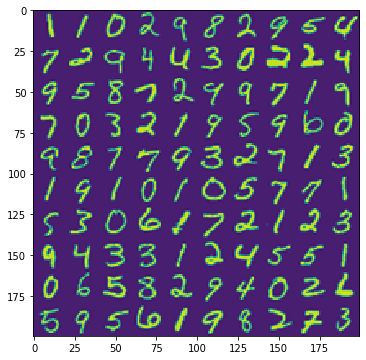

In [11]:
import random
#将400 转为 20*20图像
def toImg(row):
    width, height = 20, 20
    square = row.reshape(width, height)
    return square.T

#展示图像
def displayImg(X, indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if indices_to_display == None:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)
    big_picture = np.zeros((height * nrows, width * ncols))
    irow , icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = toImg(X[idx])
        big_picture[(irow*height):(irow*height+iimg.shape[0]),
                   (icol*width):(icol*width+iimg.shape[1])] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture, interpolation='nearest')
displayImg(X)

## 2 Convolution

In [12]:
def convolution(Xi, kernal): #(20, 20) (5, 5)
    xrow, xcol = Xi.shape
    krow, kcol = kernal.shape
    rrow, rcol = xrow - krow + 1, xcol - kcol + 1
    res = np.zeros((rrow, rcol))    
    for i in range(rrow):
        for j in range(rcol):
            res[i][j] = np.sum(Xi[i:i+krow, j:j+kcol] * kernal)
    return res # (16, 16)

## 3 Pooling

In [ ]:
def maxPooling(conv):
    # use 2*2 pooling
    row, col = conv.shape
    res = np.zeros((row // 2, col // 2))
    pooling_grad = np.zeros(conv.shape)
    for i in range(0, row, 2):
        for j in range(0, col, 2):
            m = conv[i, j]
            mr, mc = i, j
            for p in range(i, i + 2):
                for q in range(j, j + 2):
                    if conv[p, q] > m:
                        m = conv[p, q]
                        mr, mc = p, q
            res[i // 2, j // 2] = m
            pooling_grad[mr, mc] = 1
    return res, pooling_grad

## 4 Sigmod


In [ ]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

## 5 Initializate thetas

In [ ]:
input_size = 400
inrow, incol = 20, 20
num_units = 5
krow, kcol = 5, 5
prow, pcol = 2, 2
conrow, concol = inrow - krow + 1, incol - kcol + 1
hrow, hcol = (inrow - krow + 1) // 2, (incol - kcol + 1) // 2
output_size = 10

weights_size = (krow * kcol + 1 + # convolution layer
                hrow * hcol * output_size) * num_units + output_size # output layer

params = (np.random.random(size=weights_size) - 0.5) * 0.25
params.shape

# inrow, incol, num_units, krow, kcol, cnrow, cncol, hrow, hcol, output_size

In [ ]:
def encode(theta1, theta2, b1, b2):
    return np.concatenate((theta1.flatten(), theta2.flatten(), b1.flatten(), b2.flatten()))
def decode(params, krow, kcol, hrow, hcol, num_units, output_size):
    theta1 = params[: krow * kcol * num_units].reshape((num_units, krow, kcol)) # (5, 5, 5)
    theta2 = params[krow * kcol * num_units: 
                   krow * kcol * num_units + 
                    hrow * hcol * output_size * num_units].reshape((num_units, output_size, hrow, hcol)) # (5, 10, 8,8)
    b1 = params[-num_units - output_size: - output_size].reshape((num_units, 1))
    b2 = params[-output_size:].reshape((output_size, 1))
    return theta1, theta2, b1, b2
t1, t2, b1, b2 = decode(params,krow, kcol, hrow, hcol, num_units, output_size)
t1.shape, t2.shape, b1.shape, b2.shape



In [ ]:
len(encode(t1, t2, b1, b2))

## 6 Forward propagate

In [ ]:
def forwardPropagate(Xi, theta1, theta2, b1, b2):
    a1 = Xi.reshape(inrow, incol) # (20, 20)
    z2 = np.zeros((num_units, conrow, concol)) # (5, 16, 16) 
    a2 = np.zeros((num_units, conrow, concol)) # (5, 16, 16)
    pooling_grad = np.zeros((num_units, conrow, concol)) # (5, 16, 16)
    a3 = np.zeros((num_units, hrow, hcol)) # (5, 8, 8) z3 = a3
    z4 = np.zeros((output_size, 1)) # (10, 1)
    a4 = np.zeros((output_size, 1)) # (10, 1)
    for i in range(num_units):
        z2[i] = convolution(a1, theta1[i]) + b1[i] # (16, 16)
        a2[i] = sigmod(z2[i]) # (16, 16)
        a3[i], pooling_grad[i] = maxPooling(a2[i]) # (8, 8) (16, 16)
        for j in range(output_size):
            z4[j] += np.sum(a3[i] * theta2[i,j])
    for i in range(output_size):
        z4[i] += b2[i]
    a4 = sigmod(z4)
    return a1, z2, a2, pooling_grad, a3, z4, a4
a1, z2, a2, pooling_grad, a3, z4, a4  = forwardPropagate(X[0], t1, t2, b1, b2)
temp = a3[0].reshape(1, *a3[0].shape)

In [ ]:
a3[0].shape

## 7 Predict and compute accuracy

In [ ]:
def computeAccuracy(X, y, theta1, theta2, b1, b2):
    m = X.shape[0]
    correct = 0
    for i in range(m):
        a1, z2, a2, pooling_grad, a3, z4, a4 = forwardPropagate(X[i], theta1, theta2, b1, b2)
        #h = a3.flatten()
        correct += int(np.argmax(a4) + 1 == y[i])
    return "accuracy = {0}%".format(100 * correct / m)
computeAccuracy(X[:500], y, t1, t2, b1, b2)

## 8 Cost function

In [ ]:
def cost(params, X, y, learning_rate=0.):
    m = X.shape[0]
    theta1, theta2, b1, b2 = reshapeParams(params, krow, kcol, hrow, hcol, num_units, output_size)
    J = 0.
    for i in range(m):
        a1, z2, a2, pooling_grad, a3, z4, a4 = forwardPropagate(X[i], theta1, theta2, b1, b2)
        tempy = y[i].reshape((output_size, 1)) # (10, 1)
        first_term = tempy * np.log(a4) # (10, 1)
        second_term = (1 - tempy) * np.log(1 - a4) # (10, 1)
        J += -np.sum(first_term + second_term)
    J /= m
    J += (float(learning_rate) / (2 * m)) * \
        (np.sum(theta1 **2) + np.sum(theta2 ** 2))
    return J

In [ ]:
cost(params, X[:5,:], y_onehot)

In [ ]:
cost(params, X, y_onehot)

## 9 Sigmod gradient

In [ ]:
def sigmodGradient(z):
    t = sigmod(z)
    return t * (1 - t)

## 10 Backpropagation

In [ ]:
def backPropagate(params, inrow, incol, num_units, krow, kcol, 
                  conrow, concol, hrow, hcol, output_size, X, y, learning_rate=0.):
    m = X.shape[0]
    theta1, theta2, b1, b2 = decode(params, krow, kcol, hrow, hcol, num_units, output_size)
    J = 0.
    delta1 = np.zeros(theta1.shape) # (5, 5, 5)
    delta2 = np.zeros(theta2.shape) # (5, 10, 8, 8)
    
    belta1 = np.zeros(b1.shape) # (5, 1)
    belta2 = np.zeros(b2.shape) # (10, 1)
    
    for i in range(m):
        a1, z2, a2, pooling_grad, a3, z4, a4 = forwardPropagate(X[i], theta1, theta2, b1, b2)
        tempy = y[i,:].reshape((output_size, 1)) # (10, 1)
        first_term = tempy * np.log(a4) # (10, 1)
        second_term = (1 - tempy) * np.log(1 - a4) # (10, 1)
        J += -np.sum(first_term + second_term)
        
        dt2 = a4 - tempy  # (10, 1)
        belta2 += dt2  # det b2
        for j in range(num_units):
            temp = np.zeros((output_size, hrow, hcol))
            for k in range(output_size):
                temp[k] = a3[j].copy()
            delta2[j] += dt2.reshape((output_size, 1, 1)) * temp  # (10, 8, 8) det w2
            
            for k in range(output_size):
                temp[k] = theta2[j,k].copy()
            
            temp2 = dt2.reshape((output_size, 1, 1)) * temp  # (10, 8, 8)
            
            dt1 = np.zeros((conrow, concol))
            for p in range(conrow):
                for q in range(concol):
                    if pooling_grad[j,p,q] == 1.:
                        val = np.zeros((output_size, 1))
                        p1 = p // 2
                        q1 = p // 2
                        for k in range(output_size):
                            val[k,0] = theta2[j,k,p1,q1]
                        
                        dt1[p, q] = np.sum(val * dt2) * z2[j,p,q] * (1 - z2[j,p,q])
            
            belta1[j] += np.sum(dt1) # det b1
            for p in range(krow):
                for q in range(kcol):
                    delta1[j, p, q] += np.sum(a1[p:p+conrow, q:q+concol] * dt1) # det w1
    J /= m
    delta1 /= m
    delta2 /= m
    belta1 /= m
    belta2 /= m
        
    J += (float(learning_rate) / (2 * m)) * (np.sum(theta1 ** 2) + np.sum(theta2 ** 2))
    delta1 += theta1 * learning_rate / m
    delta2 += theta2 * learning_rate / m
        
    return J, encode(delta1, delta2, b1, b2)
J, grad = backPropagate(params, inrow, incol, num_units, krow, kcol, 
                  conrow, concol, hrow, hcol, output_size, X[:50], y_onehot)

In [ ]:
J

## 11 Gradient checking

In [ ]:
def checkGradient(params, grad, krow, kcol, 
                  hrow, hcol, num_units, output_size, X, y, leraning_rate=0.):
    eps = 1e-4
    n = len(params)
    for i in range(10):
        x = random.randint(0, n - 1)
        epsvec = np.zeros(n)
        epsvec[x] = eps
        cost_high = cost(params + epsvec, X, y_onehot)
        cost_low = cost(params - epsvec, X, y_onehot)
        mygrad = (cost_high - cost_low) / (2 * eps)
        print(f"Element: {x}. Numerical grad = {mygrad} BP grad = {grad[x]}")

checkGradient(params, grad, krow, kcol, hrow, hcol, num_units, output_size, X[:50], y_onehot)
#len(grad)

In [ ]:
learning_rate = 0.03

## 12 Training

In [ ]:
fmin = minimize(fun=backPropagate, x0=params,
               args=(inrow, incol, num_units, krow, kcol, 
                  conrow, concol, hrow, hcol, output_size, X[:50], y_onehot[:3500], learning_rate),
               method="TNC", jac=True, options={"maxiter": 5})
fmin

## 13 Compute accuracy

In [ ]:
def ComputeAccuracy(params, X, y):
    t1, t2, b1, b2 = decode(params,krow, kcol, hrow, hcol, num_units, output_size)
    m = X.shape[0]
    correct = 0
    for i in range(m):
        a1, z2, a2, pooling_grad, a3, z4, a4  = forwardPropagate(X[0], t1, t2, b1, b2)
        correct += int(np.argmax(a4) + 1 == y[i])
    print("accuracy = {0}%".format(100 * correct / m))
ComputeAccuracy(fmin.x, X[4000:],y[4000:])


## 14 Normal batch gradient
